In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
from nltk import tokenize
from datetime import datetime
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from numba import jit, prange
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.models import SequenceTagger
from flair.data import Sentence
from segtok.segmenter import split_single
from statistics import mean

sid = SentimentIntensityAnalyzer()
classifier = TextClassifier.load("en-sentiment")

2021-04-08 07:57:22,193 loading file C:\Users\Chris\.flair\models\sentiment-en-mix-distillbert_4.pt


In [3]:
# input data
nvidia_df = pd.read_csv("../00_data/nvidia_caption_data_06APR.gz")

In [4]:
# Cleaning step1: fix the issue were the data was appended incorrectly
correct_df = nvidia_df.iloc[0:16268].copy()
incorrect_df = nvidia_df.iloc[16268:].copy()

# relable incoorect columns to be appended back correctly
incorrect_df.rename(
    columns={
        "captionString": "drop",
        "Unnamed: 0": "Index",
        "Unnamed: 0.1": "videoID",
        "videoID": "datePub",
        "datePub": "searchedDate",
        "searchedDate": "VideoTitle",
        "VideoTitle": "channelTitle",
        "channelTitle": "viewCount",
        "viewCount": "likeCount",
        "likeCount": "dislikeCount",
        "dislikeCount": "captionString",
    },
    inplace=True,
)

# drop the exccess column created by AWS appending
incorrect_df = incorrect_df.drop(columns=["drop"])

# relable columns to match the corrected df
correct_df.rename(columns={"Unnamed: 0.1": "Index"}, inplace=True)
correct_df = correct_df.drop(columns=["Unnamed: 0"])

# create new nvida data frame to begin cleaning and working with
nvidia_df_1 = correct_df.append(incorrect_df, sort=False)

# initialize correct types of data for each column
nvidia_df_1["VideoTitle"] = nvidia_df_1["VideoTitle"].astype("str")
nvidia_df_1["datePub"] = pd.to_datetime(
    nvidia_df_1["datePub"], format="%Y-%m-%d %H:%M:%S", utc=True
)
nvidia_df_1["searchedDate"] = pd.to_datetime(
    nvidia_df_1["searchedDate"], format="%Y-%m-%d %H:%M:%S", utc=True
)
nvidia_df_1["channelTitle"] = nvidia_df_1["channelTitle"].astype("str")
nvidia_df_1["viewCount"] = nvidia_df_1["viewCount"].astype("int")
nvidia_df_1["likeCount"] = nvidia_df_1["likeCount"].astype("int")
nvidia_df_1["dislikeCount"] = nvidia_df_1["dislikeCount"].astype("int")
nvidia_df_1["captionString"] = nvidia_df_1["captionString"].astype("str")

# define a cleaning function to clean and standardize caption strings
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("\\[[^][]*]", "", raw)
    result = re.sub("<[a][^>]*>(.+?)</[a]>", "Link.", result)
    result = re.sub("&gt;", "", result)
    result = re.sub("&#x27;", "'", result)
    result = re.sub("&quot;", '"', result)
    result = re.sub("&#x2F;", " ", result)
    result = re.sub("<p>", " ", result)
    result = re.sub("</i>", "", result)
    result = re.sub("&#62;", "", result)
    result = re.sub("<i>", " ", result)
    result = re.sub("\n", "", result)
    result = re.sub("     ", "", result)
    return result


nvidia_df_1["captionString"] = nvidia_df_1["captionString"].apply(clean)
nvidia_df_1["VideoTitle"] = nvidia_df_1["VideoTitle"].apply(clean)

# for i in range(len(nvidia_df_1["captionString"])):
#    nvidia_df_1["captionString"][i] = clean(nvidia_df_1["captionString"][i])

In [5]:
nvidia_df_1.dtypes

Index                         object
videoID                       object
datePub          datetime64[ns, UTC]
searchedDate     datetime64[ns, UTC]
VideoTitle                    object
channelTitle                  object
viewCount                      int32
likeCount                      int32
dislikeCount                   int32
captionString                 object
dtype: object

In [ ]:
sid = SentimentIntensityAnalyzer()

# nvidia_df_1["videoTitleSentimentScore_vader_pos"] = [
#     sid.polarity_scores(x)["pos"] for x in nvidia_df_1["VideoTitle"]
# ]

# nvidia_df_1["videoTitleSentimentScore_vader_neg"] = [
#     sid.polarity_scores(x)["neg"] for x in nvidia_df_1["VideoTitle"]
# ]

# nvidia_df_1["captionSentimentScore_vader_pos"] = [
#     sid.polarity_scores(x)["pos"] for x in nvidia_df_1["captionString"]
# ]

# nvidia_df_1["captionSentimentScore_vader_neg"] = [
#     sid.polarity_scores(x)["neg"] for x in nvidia_df_1["captionString"]
# ]

# nvidia_df_1["captionSentimentScore_vader_com"] = [
#     sid.polarity_scores(x)["compound"] for x in nvidia_df_1["captionString"]
# ]

# nvidia_df_1["videoTitleSentimentScore_vader_com"] = [
#     sid.polarity_scores(x)["compound"] for x in nvidia_df_1["VideoTitle"]
# ]


#####
# Create one socre a cycle through to pullout late to aave on speed
#####

nvidia_df_1["videoTitleSentimentScore_vader_scores"] = [
    sid.polarity_scores(x) for x in nvidia_df_1["VideoTitle"]
]

nvidia_df_1["videoTitleSentimentScore_caption_scores"] = [
    sid.polarity_scores(x) for x in nvidia_df_1["captionString"]
]

In [7]:
classifier = TextClassifier.load("en-sentiment")

# utilize regular expressions to split large stings into sentences that are centered around the key words


def search(target, text, context=6):
    # It's easier to use re.findall to split the string,
    # as we get rid of the punctuation
    words = re.findall(r"\w+", text)

    matches = (i for (i, w) in enumerate(words) if w.lower() == target)
    for index in matches:
        if index < context // 2:
            yield words[0 : context + 1]
        elif index > len(words) - context // 2 - 1:
            yield words[-(context + 1) :]
        else:
            yield words[index - context // 2 : index + context // 2 + 1]


def flair_predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()["value"]
    if value == "POSITIVE":
        result = text.to_dict()["labels"][0]["confidence"]
    else:
        result = -(text.to_dict()["labels"][0]["confidence"])
    return round(result, 3)


def vader_predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    # stacked_embeddings.embed(text)
    else:
        score = sid.polarity_scores(" ".join(sentence))
        result = score["pos"]
        return round(result, 3)


def get_scores(sentences, flairPredict=True):
    """ Call predict on every sentence of a text """
    results = []

    if flairPredict == True:
        for i in range(0, len(sentences)):
            results.append(flair_predict(sentences[i]))
        return results
    else:
        for i in range(0, len(sentences)):
            results.append(vader_predict(sentences[i]))
        return results


def get_scores_single_cap(sentences, flairPredict=True):
    """ Call predict on single caption string """
    if flairPredict == True:
        results = []
        results.append(flair_predict(sentences))
        return results
    else:
        results = []
        results.append(vader_predict(sentences))
        return results


def get_sum(scores):
    result = round(sum(scores), 3)
    return result


def get_avg(scores):
    if len(scores) == 0:
        return 0
    else:
        result = round((sum(scores) / len(scores)), 3)
        return result

2021-04-08 07:59:20,248 loading file C:\Users\Chris\.flair\models\sentiment-en-mix-distillbert_4.pt


In [8]:
nvidia_df_1["caption_list_split_by_nvidia_10words"] = [
    list(search("nvidia", x, 10)) for x in nvidia_df_1["captionString"]
]

nvidia_df_1["caption_list_split_by_nvidia_20words"] = [
    list(search("nvidia", x, 20)) for x in nvidia_df_1["captionString"]
]

nvidia_df_1["caption_list_split_by_nvidia_35words"] = [
    list(search("nvidia", x, 35)) for x in nvidia_df_1["captionString"]
]

In [ ]:
nvidia_df_1

In [10]:
nvidia_df_1["caption_list_split_by_nvidia_10words_flairscores"] = [
    get_scores(x, flairPredict = True) for x in nvidia_df_1["caption_list_split_by_nvidia_10words"]
]

nvidia_df_1["caption_list_split_by_nvidia_20words_flairscores"] = [
    get_avg(get_scores(x, flairPredict = True)) for x in nvidia_df_1["caption_list_split_by_nvidia_20words"]
]

nvidia_df_1["caption_list_split_by_nvidia_35words_flairscores"] = [
    get_avg(get_scores(x, flairPredict = True)) for x in nvidia_df_1["caption_list_split_by_nvidia_35words"]
]

KeyboardInterrupt: 

In [ ]:
#### Not needed anymore

# nvidia_df_1["caption_list_split_by_nvidia_10words_flairAvgScore"] = [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_10words_flairscores"]
# ]

# nvidia_df_1["caption_list_split_by_nvidia_20words_flairAvgScore"] = [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_20words_flairscores"]
# ]
    
# nvidia_df_1["caption_list_split_by_nvidia_35words_flairAvgScore"] = [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_35words_flairscores"]
# ]

In [ ]:
nvidia_df_1["caption_list_split_by_nvidia_10words_vaderscores"] = [
    get_avg(get_scores(x, vaderPredict = False)) for x in nvidia_df_1["caption_list_split_by_nvidia_10words"]
]

# nvidia_df_1["caption_list_split_by_nvidia_10words_vaderAvgScore"] = 
# [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_10words_vaderscores"]
# ]

nvidia_df_1["caption_list_split_by_nvidia_20words_vaderscores"] = [
    get_avg(get_scores(x, vaderPredict = False)) for x in nvidia_df_1["caption_list_split_by_nvidia_20words"]
]

# nvidia_df_1["caption_list_split_by_nvidia_20words_vaderAvgScore"] = 
# [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_20words_vaderscores"]
# ]

nvidia_df_1["caption_list_split_by_nvidia_35words_vaderscores"] = [
    get_avg(get_scores(x, vaderPredict = False)) for x in nvidia_df_1["caption_list_split_by_nvidia_35words"]
]

# nvidia_df_1["caption_list_split_by_nvidia_35words_vaderAvgScore"] = 
# [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_35words_vaderscores"]
# ]

In [ ]:
nvidia_df_1["num_days_since_pub"] = np.ceil(
    (nvidia_df_1["searchedDate"] - nvidia_df_1["datePub"]) / np.timedelta64(1, "D")
)
nvidia_df_1["viewcounts_weighted"] = (
    nvidia_df_1["viewCount"] / nvidia_df_1["num_days_since_pub"]
)
nvidia_df_1["like_count_weighted"] = (
    nvidia_df_1["likeCount"] / nvidia_df_1["num_days_since_pub"]
)
nvidia_df_1["dislike_count_weighted"] = (
    nvidia_df_1["dislikeCount"] / nvidia_df_1["num_days_since_pub"]
)
nvidia_df_1["like_dislike_ratio"] = nvidia_df_1["likeCount"] / (
    nvidia_df_1["likeCount"] + nvidia_df_1["dislikeCount"]
)
nvidia_df_1["weighted_like_dislike_ratio"] = nvidia_df_1["like_count_weighted"] / (
    nvidia_df_1["like_count_weighted"] + nvidia_df_1["dislike_count_weighted"]
)
nvidia_df_1["like_dislike_ratio_by_viewcounts_weighted"] = (
    nvidia_df_1["like_dislike_ratio"] * nvidia_df_1["viewcounts_weighted"]
)
nvidia_df_1["Date"] = pd.to_datetime(
    nvidia_df_1["searchedDate"], format="%Y-%m-%d", utc=True
).dt.date

### X_feautures_pre_merge

In [ ]:
X_feautures_pre_merge = nvidia_df_1.copy()

# X_feautures_pre_merge["Date"] = pd.to_datetime(
#     X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
# ).dt.date

pre_nan_drop_X_feautures_pre_merge = X_feautures_pre_merge_1.groupby(pd.Grouper(key="searchedDate", freq='H', offset = "30min")).mean()

post_nan_drop_X_feautures_post_merge = pre_nan_drop_X_feautures_pre_merge [pre_nan_drop_X_feautures_pre_merge ['viewCount'].notna()]

In [ ]:
post_nan_drop_X_feautures_post_merge

In [ ]:
post_nan_drop_X_feautures_post_merge.to_csv("../00_data/By_hour_feature_aggrigated_flairvader_06APR.gz", compression = "gzip")

### Plot number of vidoes per day

In [ ]:
nvidia_df_2 = nvidia_df_1.copy()
nvidia_df_2["VideoTitle"] = nvidia_df_2["VideoTitle"].apply(clean)

In [8]:
data_df = pd.to_datetime(
    nvidia_df_2["searchedDate"], format="%Y-%m-%d", utc=True
).dt.date

In [9]:
data_df.value_counts()

2020-10-26    335
2020-11-20    325
2020-10-29    309
2020-10-07    300
2021-02-19    300
             ... 
2021-01-07     25
2020-12-15     25
2020-12-12     25
2020-12-21     25
2021-01-04     25
Name: searchedDate, Length: 136, dtype: int64

In [10]:
type(nvidia_df["searchedDate"][0])

str

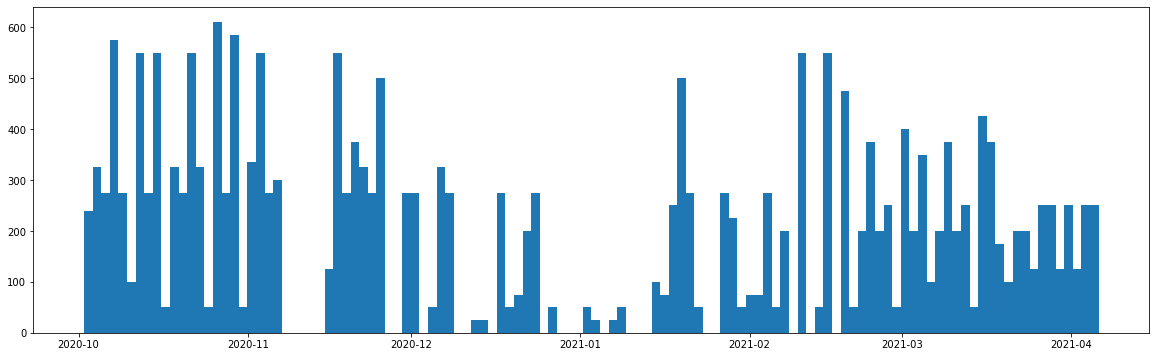

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.hist(
    (pd.to_datetime(nvidia_df_2["searchedDate"], format="%Y-%m-%d", utc=True).dt.date),
    bins=118,
)

plt.show()